# OR Utilization Analysis

This notebook is converted from the original Python script (`or_utilization_analysis.py`).  
It contains code for:
- Loading surgical operating room dataset
- Computing planned vs actual durations
- Utilization % per room
- Turnaround times
- Visualizations (heatmap, bar chart, boxplot, histogram)
- Quick insights

Each section will run the analysis and display the output charts inline.


In [15]:
import os
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update({'figure.max_open_warning': 0})

In [16]:
# --- Helper functions ---

def safe_parse_datetime(df, col, dayfirst=True):
    """Try to parse a datetime column in-place, returning a Series (may contain NaT).
    If column doesn't exist, returns a Series of NaT.
    `dayfirst=True` treats ambiguous dates as DD/MM/YYYY.
    """    
    if col in df.columns:
        return pd.to_datetime(df[col], errors='coerce', dayfirst=dayfirst, infer_datetime_format=True)
    else:
        return pd.Series(pd.NaT, index=df.index)

def compute_durations(df, enter_col, exit_col, newcol):
    enter = safe_parse_datetime(df, enter_col)
    exit = safe_parse_datetime(df, exit_col)
    mask = (exit < enter) & enter.notna() & exit.notna()
    exit.loc[mask] = exit.loc[mask] + pd.Timedelta(days=1)
    df[newcol] = (exit - enter).dt.total_seconds() / 3600.0
    return df

In [ ]:
def compute_turnarounds(df, room_col='ROOM', date_col='PLANNED_PATIENT_CALL_TIME',
                        enter_col='ACTUAL_ENTER_OR_TIME', exit_col='ACTUAL_EXIT_OR_TIME'):
    df = df.copy()
    df['actual_enter'] = safe_parse_datetime(df, enter_col)
    df['actual_exit'] = safe_parse_datetime(df, exit_col)
    if date_col in df.columns:
        df['_booking_date'] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True).dt.date
    else:
        df['_booking_date'] = df['actual_enter'].dt.date
    df = df.sort_values([room_col, '_booking_date', 'actual_enter'])
    turn_rows = []
    for (room, bdate), group in df.groupby([room_col, '_booking_date']):
        group = group.sort_values('actual_enter')
        prev_exit = None
        for idx, row in group.iterrows():
            if pd.isna(row['actual_enter']) or prev_exit is None or pd.isna(prev_exit):
                turnaround = np.nan
            else:
                turnaround = (row['actual_enter'] - prev_exit).total_seconds() / 60.0
            turn_rows.append({
                'index': idx,
                'ROOM': room,
                'BOOKING_DATE': bdate,
                'TURNAROUND_MIN': turnaround
            })
            prev_exit = row['actual_exit']
    turn_df = pd.DataFrame(turn_rows).set_index('index')
    if not turn_df.empty:
        df = df.join(turn_df[['TURNAROUND_MIN', 'BOOKING_DATE']])
    else:
        df['TURNAROUND_MIN'] = np.nan
        df['BOOKING_DATE'] = pd.NaT
    
    df = df.drop(columns=['actual_enter', 'actual_exit', '_booking_date'], errors='ignore')

    # --- Filter unrealistic/outlier values --------------------------------------------------------------------------------
    # for example: turnaround < 0, which implies data entry error
    # OR turnaround taking >= 660 min, which implies there is just no next surgery scheduled soon
    # (and the OR is free for a 11-hour interval)
    invalid_mask = (df['TURNAROUND_MIN'] < 0) | (df['TURNAROUND_MIN'] >= 660)
    dropped_records = df.loc[invalid_mask, ['OPERATION_ID', 'TURNAROUND_MIN']]

    dropped_count = invalid_mask.sum()
    if dropped_count > 0:
        print(f"[INFO] Dropping {dropped_count} turnaround records < 0, or >= 11h (likely data errors).")
        display(dropped_records)  # displays dataframe of dropped turnaround times

    # set them to NaN
    df.loc[invalid_mask, 'TURNAROUND_MIN'] = np.nan

    return df

In [ ]:
# --- Visualization functions ---

def make_heatmap(df, room_col='ROOM', enter_col='ACTUAL_ENTER_OR_TIME'):
    df2 = df.copy()
    df2['actual_enter'] = safe_parse_datetime(df2, enter_col)
    df2 = df2.dropna(subset=['actual_enter'])
    df2['day'] = df2['actual_enter'].dt.day_name()
    df2['hour'] = df2['actual_enter'].dt.hour
    pivot = pd.pivot_table(df2, index='day', columns='hour', values=room_col, aggfunc='count', fill_value=0)
    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    pivot = pivot.reindex(weekdays).fillna(0)
    plt.figure(figsize=(14,6))
    sns.heatmap(pivot, annot=True, fmt='g')
    plt.title('Heatmap: surgeries by weekday vs hour')
    plt.ylabel('Day')
    plt.xlabel('Hour of day')
    plt.show()

def make_utilization_bar(df, room_col='ROOM', duration_col='ACTUAL_DURATION_HRS', date_col='PLANNED_PATIENT_CALL_TIME'):
    df2 = df.copy()
    if duration_col not in df2.columns:
        df2 = compute_durations(df2, 'ACTUAL_ENTER_OR_TIME', 'ACTUAL_EXIT_OR_TIME', duration_col)
    if date_col in df2.columns:
        df2['_booking_date'] = pd.to_datetime(df2[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True).dt.date
    else:
        df2['_booking_date'] = pd.to_datetime(df2['ACTUAL_ENTER_OR_TIME'], errors='coerce', dayfirst=True, infer_datetime_format=True).dt.date
    summary = df2.groupby(['ROOM']).agg(
        total_actual_hours = (duration_col, 'sum'),
        unique_days = ('_booking_date', lambda x: x.dropna().nunique())
    )
    summary['available_hours'] = summary['unique_days'] * 24.0
    summary['utilization_pct'] = (summary['total_actual_hours'] / summary['available_hours']) * 100.0
    summary = summary.sort_values('utilization_pct', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=summary.index, y='utilization_pct', data=summary.reset_index())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Utilization (%)')
    plt.title('Utilization % by ROOM')
    plt.show()
    return summary

def make_turnaround_boxplot(df, room_col='ROOM', turnaround_col='TURNAROUND_MIN'):
    df2 = df.copy()
    if turnaround_col not in df2.columns:
        df2 = compute_turnarounds(df2)
    plotdf = df2.dropna(subset=[turnaround_col])
    if plotdf.empty:
        print('No turnaround data available to plot.')
        return None
    plt.figure(figsize=(10,6))
    sns.boxplot(x=room_col, y=turnaround_col, data=plotdf)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Turnaround (minutes)')
    plt.title('Turnaround Times by ' + room_col)
    plt.show()
    return plotdf

def make_turnaround_histogram(df, room_col='ROOM', turnaround_col='TURNAROUND_MIN'):
    df3 = df.copy()
    if turnaround_col not in df3.columns:
        df3 = compute_turnarounds(df3)
    plotdf = df3.dropna(subset=[turnaround_col])
    if plotdf.empty:
        print('No turnaround data available to plot.')
        return None
    plt.figure(figsize=(12, 6))
    sns.histplot(data=plotdf, x=turnaround_col, hue=room_col, element="step", kde=True, stat="density", common_norm=False)
    plt.xlabel("Turnaround time (minutes)")
    plt.ylabel("Density")
    plt.title('Distribution of Turnaround Times by ' + room_col)
    plt.show()
    return plotdf

In [ ]:
def short_insights(util_summary, df, turnaround_col='TURNAROUND_MIN'):
    insights = {}
    if util_summary is None or util_summary.empty:
        insights['utilization'] = 'No utilization summary available.'
    else:
        busiest = util_summary['utilization_pct'].idxmax()
        under = util_summary['utilization_pct'].idxmin()
        insights['busiest_room'] = (busiest, util_summary.loc[busiest, 'utilization_pct'])
        insights['most_underutilized_room'] = (under, util_summary.loc[under, 'utilization_pct'])
    if 'TURNAROUND_MIN' in df.columns and df['TURNAROUND_MIN'].dropna().any():
        t = df['TURNAROUND_MIN'].dropna()
        insights['turnaround_median_min'] = float(t.median())
        insights['turnaround_mean_min'] = float(t.mean())
    else:
        insights['turnaround'] = 'No turnaround values computed.'
    return insights

In [20]:
# --- Load your dataset ---
excel_path = "Final_Cleaned_Dataset_OPTIC_7.xlsx"  # change if needed
df = pd.read_excel(excel_path)
print(f"Loaded {len(df)} rows, {len(df.columns)} columns")

# Convert date columns
datetime_cols = ['PLANNED_ENTER_OR_TIME', 'PLANNED_EXIT_OR_TIME',
                 'ACTUAL_ENTER_OR_TIME', 'ACTUAL_EXIT_OR_TIME',
                 'PLANNED_RECEPTION_IN_TIME', 'PLANNED_PATIENT_FETCH_TIME',
                 'PLANNED_PATIENT_CALL_TIME']
for c in datetime_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True, infer_datetime_format=True)

# Compute durations and turnarounds
df = compute_durations(df, 'PLANNED_ENTER_OR_TIME', 'PLANNED_EXIT_OR_TIME', 'PLANNED_DURATION_HRS')
df = compute_durations(df, 'ACTUAL_ENTER_OR_TIME', 'ACTUAL_EXIT_OR_TIME', 'ACTUAL_DURATION_HRS')
df = compute_turnarounds(df)
df.head()

Loaded 248784 rows, 66 columns
[INFO] Dropping 521 turnaround records < 0, or >= 11h (likely data errors).


,OPERATION_ID,TURNAROUND_MIN
229686,680690,1771.0
167703,741977,-84.0
139609,614549,-17.0
214318,717438,673.0
163953,742602,-128.0
...,...,...
195439,758063,1078.0
172217,763760,669.0
176191,774466,818.0
198921,783994,684.0


,Unnamed: 0,OPERATION_ID,LOCATION,ROOM,CASE_STATUS,OPERATION_TYPE,EMERGENCY_PRIORITY,PLANNED_PATIENT_CALL_TIME,PLANNED_PATIENT_FETCH_TIME,PLANNED_RECEPTION_IN_TIME,...,DIFF_USAGE_DURATION,ENTER_START_DELAY,KNIFE_START_DELAY,EXIT_OR_DELAY,Is_Late,Delay_Category,PLANNED_DURATION_HRS,ACTUAL_DURATION_HRS,TURNAROUND_MIN,BOOKING_DATE
93380,103150,579857,AH Day Surgery Theatre,AH_DSOR01,Actualised,Elective,0,2019-02-14 08:20:00,2019-02-14 08:20:00,2019-02-14 08:20:00,...,39,26,40,65,1,Unspecified (late),0.833333,1.483333,NaN,2019-02-14
83578,92398,579449,AH Day Surgery Theatre,AH_DSOR01,Final,Elective,0,2019-02-21 14:00:00,2019-02-21 14:00:00,2019-02-21 14:00:00,...,25,-34,-33,-9,0,No Delay,0.583333,1.000000,NaN,2019-02-21
83558,92378,579447,AH Day Surgery Theatre,AH_DSOR01,Final,Elective,0,2019-02-21 14:31:00,2019-02-21 14:31:00,2019-02-21 14:31:00,...,-17,-2,-12,-19,0,No Delay,0.750000,0.466667,3.0,2019-02-21
78390,86762,580188,AH Day Surgery Theatre,AH_DSOR01,Actualised,Elective,0,2019-02-27 08:35:00,2019-02-27 08:35:00,2019-02-27 08:35:00,...,-8,5,-8,-3,0,No Delay,0.666667,0.533333,NaN,2019-02-27
78180,86538,581928,AH Day Surgery Theatre,AH_DSOR01,Final,Elective,0,2019-02-28 09:20:00,2019-02-28 09:20:00,2019-02-28 09:20:00,...,9,-64,-55,-55,0,No Delay,0.583333,0.733333,NaN,2019-02-28


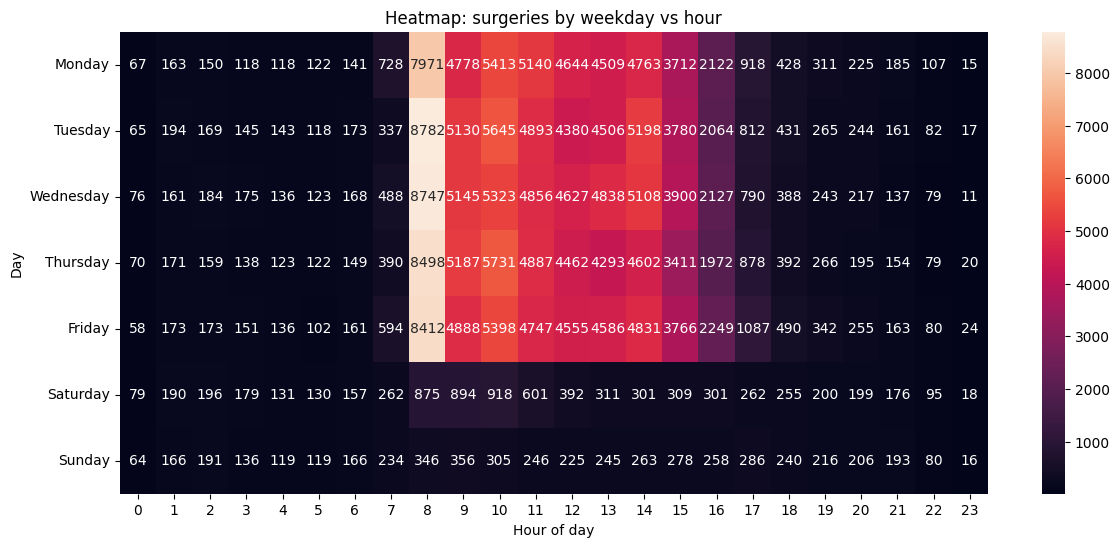

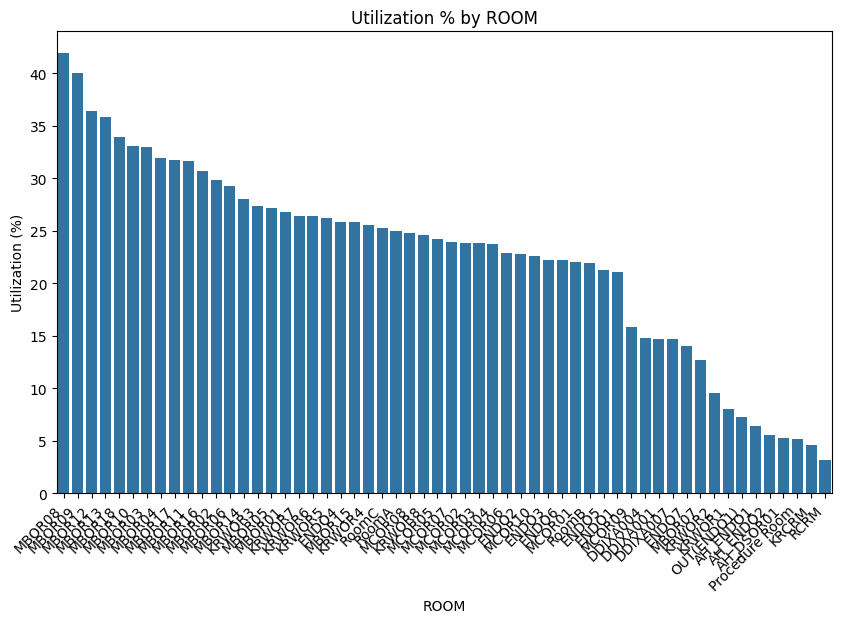

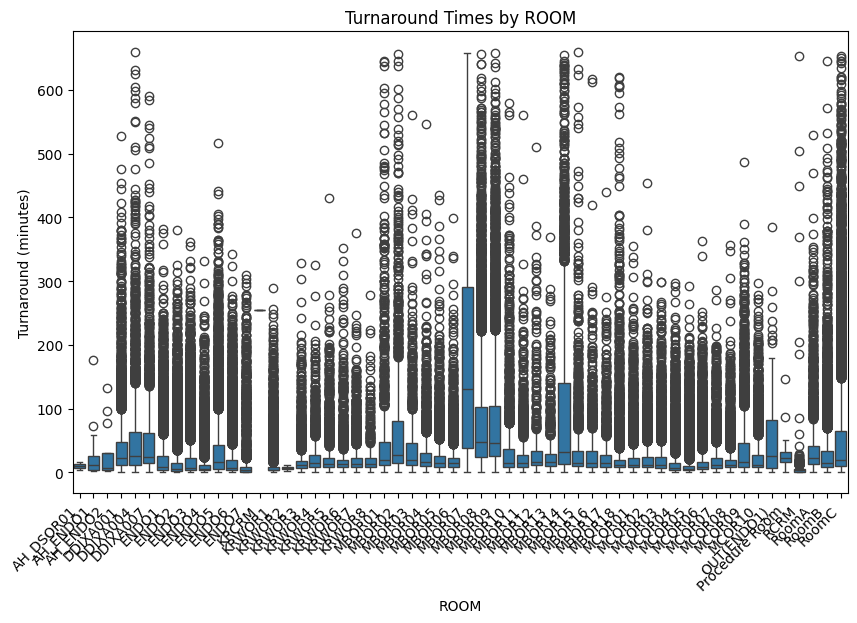

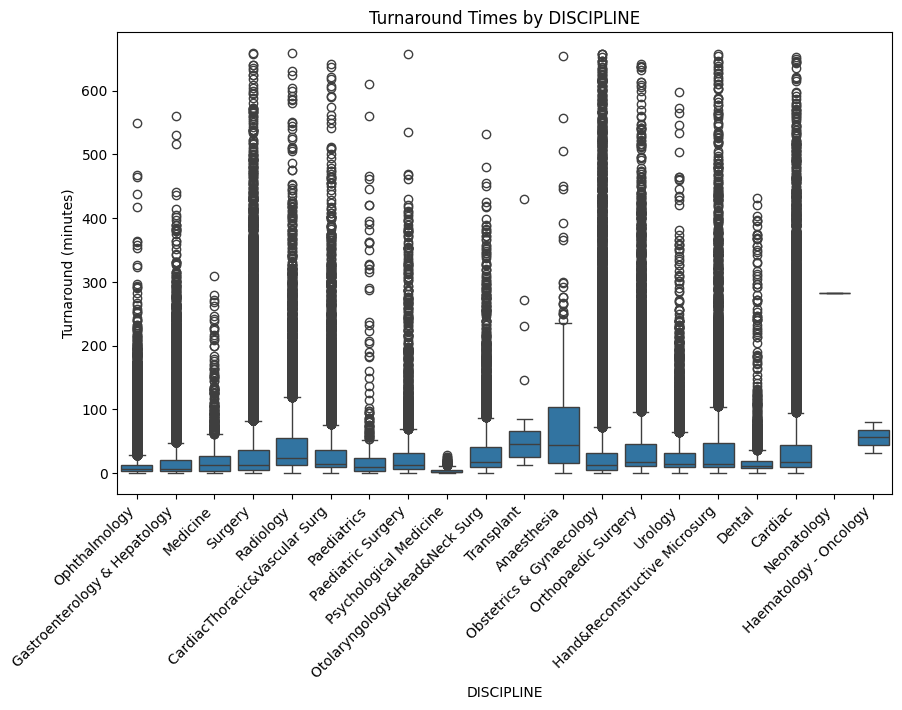

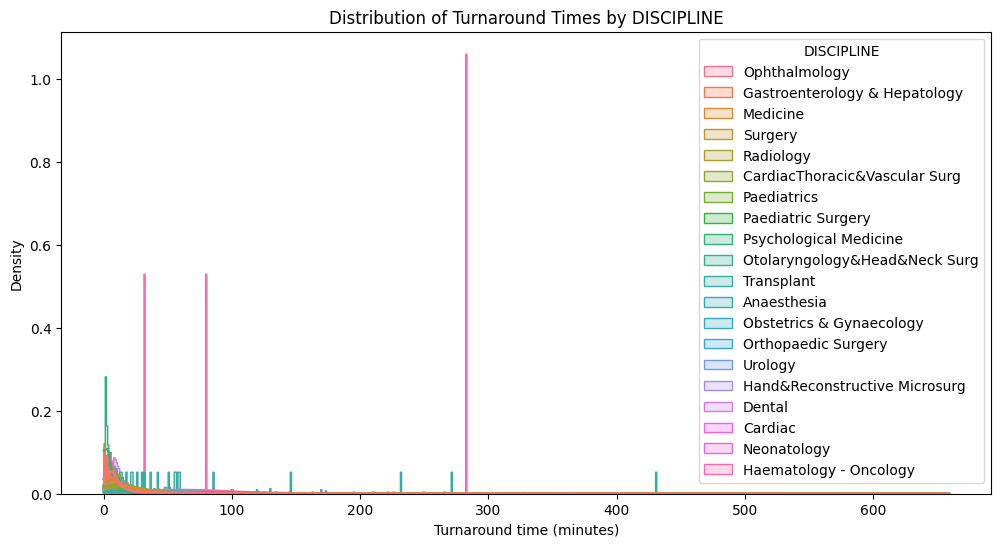

,Unnamed: 0,OPERATION_ID,LOCATION,ROOM,CASE_STATUS,OPERATION_TYPE,EMERGENCY_PRIORITY,PLANNED_PATIENT_CALL_TIME,PLANNED_PATIENT_FETCH_TIME,PLANNED_RECEPTION_IN_TIME,...,DIFF_USAGE_DURATION,ENTER_START_DELAY,KNIFE_START_DELAY,EXIT_OR_DELAY,Is_Late,Delay_Category,PLANNED_DURATION_HRS,ACTUAL_DURATION_HRS,TURNAROUND_MIN,BOOKING_DATE
83558,92378,579447,AH Day Surgery Theatre,AH_DSOR01,Final,Elective,0,2019-02-21 14:31:00,2019-02-21 14:31:00,2019-02-21 14:31:00,...,-17,-2,-12,-19,0,No Delay,0.750000,0.466667,3.0,2019-02-21
78143,86501,579753,AH Day Surgery Theatre,AH_DSOR01,Final,Elective,0,2019-02-28 08:35:00,2019-02-28 08:35:00,2019-02-28 08:35:00,...,14,41,40,55,1,Other Case Issues,0.583333,0.816667,16.0,2019-02-28
63176,69838,571951,AH Endoscopy Center,AH_ENDO1,Actualised,Elective,0,2019-01-15 11:37:00,2019-01-15 11:37:00,2019-01-15 11:37:00,...,5,-4,5,1,1,Unspecified (late),0.450000,0.533333,3.0,2019-01-15
63163,69823,573727,AH Endoscopy Center,AH_ENDO1,Actualised,Elective,0,2019-01-15 12:14:00,2019-01-15 12:14:00,2019-01-15 12:14:00,...,5,-7,-1,-2,0,No Delay,0.450000,0.533333,2.0,2019-01-15
58401,64554,575424,AH Endoscopy Center,AH_ENDO1,Actualised,Elective,0,2019-01-17 11:50:00,2019-01-17 11:50:00,2019-01-17 11:50:00,...,10,26,23,36,1,Unspecified (late),0.366667,0.533333,176.0,2019-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158508,175527,786528,ICL,RoomC,Actualised,Elective,0,2022-02-24 16:35:00,2022-02-24 16:35:00,2022-02-24 16:35:00,...,-115,57,44,-58,1,Unspecified (late),2.750000,0.833333,91.0,2022-02-24
158437,175449,791923,ICL,RoomC,Actualised,Emergency,P0,2022-02-25 10:25:00,2022-02-25 10:25:00,2022-02-25 10:25:00,...,-47,15,25,-32,1,Unspecified (late),2.250000,1.466667,11.0,2022-02-25
158408,175419,791686,ICL,RoomC,Actualised,Elective,0,2022-02-25 12:00:00,2022-02-25 12:00:00,2022-02-25 12:00:00,...,-35,20,6,-15,1,Unspecified (late),1.750000,1.166667,12.0,2022-02-25
158389,175400,791850,ICL,RoomC,Actualised,Elective,0,2022-02-25 14:00:00,2022-02-25 14:00:00,2022-02-25 14:00:00,...,-61,-30,-43,-91,0,No Delay,1.750000,0.733333,0.0,2022-02-25


In [21]:
# --- Visualizations ---

# Heatmap
make_heatmap(df)

# Utilization bar chart
util_summary = make_utilization_bar(df)

# Turnaround boxplot (by ROOM)
make_turnaround_boxplot(df, room_col='ROOM')

# No turnaround histogram (by ROOM) plotted, since too many rooms

# Turnaround boxplot (by DISCIPLINE)
make_turnaround_boxplot(df, room_col='DISCIPLINE')

# Turnaround histogram (by DISCIPLINE)
make_turnaround_histogram(df, room_col='DISCIPLINE')

In [22]:
# --- Quick Insights ---
insights = short_insights(util_summary, df)
insights

{'busiest_room': ('MBOR08', 41.87620055225403),
 'most_underutilized_room': ('RCRM', 3.1699222053103333),
 'turnaround_median_min': 12.0,
 'turnaround_mean_min': 34.994674805641075}